<a href="https://colab.research.google.com/github/fabiorfc/Epidemiologia-Matematica/blob/master/Modelagem_SIR_Vis%C3%A3o_di%C3%A1ria_S%C3%A3o_Paulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análises preliminares

Neste notebook fooram avaliadas as curvas de incidência, prevalência e letalidade de casos de coronavírus da cidade de São Paulo.

Além disso, também foi estimada a curva SIR, modelo compartimental que segmenta a população em Suscetíveis, Infectados e Removidos.

___
## 1) Escopo do notebook

* i. Definição das equações diferenciais
* ii. Preparação do ambiente
* iii. Avaliação das curvas de prevalência
* iiii. Modelagem SIR

## 1.1) Definição da dinâmica entre os compartimentos populacionais

Para este trabalho, a dinâmica entre os compartimentos populacionais será defido da seguinte forma:

Suscetíveis -- $^{\beta * S(t) * I(t) * N^{-1}}$ --> Infectados

Infectados -- $^{I(t) * (d + \gamma)}$ --> Removidos

Aqui, serão considerados como removidos do grupo de infectados, os indivíduos recuperados e aqueles que não resistiram ao sintomas mais graves.

As equações diferenciais que definem a dinâmica proposta neste trabalho é:

**Variação da população Suscetível:**
>\begin{equation}
\frac {d S(t)}{dt} = -\frac{\beta I(t)  S(t)}{N} \tag{1}
\end{equation}

**Variação da população de Infectados:**
>\begin{equation}
\frac {d I(t)}{dt} = \frac{\beta I(t)  S(t)}{N}  - I(t) (d + \gamma) \tag{2}
\end{equation}

**Variação da população de Infectados:**
>\begin{equation}
\frac {d R(t)}{dt} = I(t) (d + \gamma) \tag{3}
\end{equation}



___
## 2) Preparação do ambiente

### 2.1) Libraries utilizadas

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

### 2.2) Leitura dos dados

In [122]:
sao_paulo = pd.read_csv('sao_paulo.csv')
sao_paulo.tail(2)

,regiao,estado,municipio,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,infectados,infectados_log,infectados_uti,data_estimada_acometimento,letalidade_01,prevalencia,incidencia
115,Sudeste,SP,São Paulo,SAO PAULO,2020-07-20,30,12252023,166348,275,8799,21,NaN,637608.695652,13.365480,12497.130435,2020-07-02,0.052895,1357.718640,2.244527
116,Sudeste,SP,São Paulo,SAO PAULO,2020-07-21,30,12252023,167801,1453,8920,121,NaN,646376.811594,13.379138,12668.985507,2020-07-03,0.053158,1369.577906,11.859266


### 2.3) Funções

In [123]:
def series_de_acometidos(cidade, variavel, tempo):
  """Funcao para gerar a serie de acometidos"""
  acometidos, acometidos_teorico, acometidos_observados, duracao_pandemia = [], [], [], []
  for i in range(len(cidade) + tempo):
    if i == 0:
      acometidos.append(1)
      acometidos_teorico.append(1)
      acometidos_observados.append(np.nan)
      duracao_pandemia.append(i)
    elif i > 0 and i <= tempo:
      acometidos.append(np.nan)
      acometidos_teorico.append(np.nan)
      acometidos_observados.append(np.nan)
      duracao_pandemia.append(i)
    elif i > tempo:
      acometidos.append(cidade[variavel][i-tempo])
      acometidos_teorico.append(np.nan)
      acometidos_observados.append(cidade[variavel][i-tempo])
      duracao_pandemia.append(i)    
  return acometidos, acometidos_teorico, acometidos_observados, duracao_pandemia

def R_0(beta, gamma, d):
    """Funcoes para calcular o valor de R0"""
    return beta / (gamma + d)

def EDO(y, t, N, beta, gamma, d):
    """Funcao para gerar as curvas SIR"""
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - I * (gamma + d)
    dRdt = I * (gamma + d)
    return dSdt, dIdt, dRdt

___
## 3) Análise simultânea das Cidades

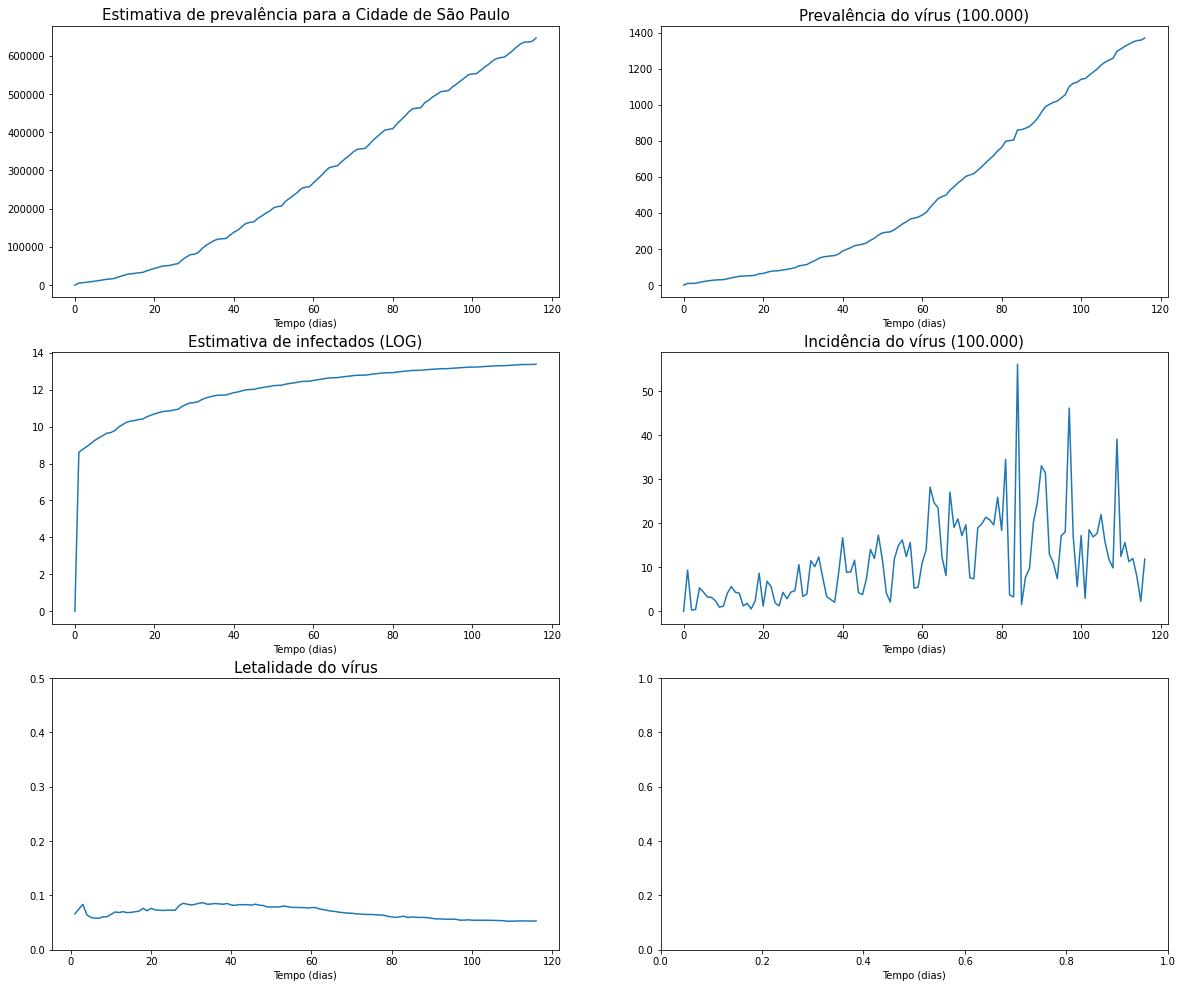

In [124]:
#Curvas de demandas por leitos de UTI
fig, axs = plt.subplots(3,2, figsize = (20,17))

axs[0,0].plot(sao_paulo["infectados"], label = 'São Paulo')
axs[0,0].set_title('Estimativa de prevalência para a Cidade de São Paulo', fontsize = 15)

axs[0,1].plot(sao_paulo['prevalencia'], label = 'São Paulo')
axs[0,1].set_title('Prevalência do vírus (100.000)', fontsize = 15)

axs[1,0].plot(sao_paulo["infectados_log"], label = 'São Paulo')
axs[1,0].set_title('Estimativa de infectados (LOG)', fontsize = 15)

axs[1,1].plot(sao_paulo['incidencia'], label = 'São Paulo')
axs[1,1].set_title('Incidência do vírus (100.000)', fontsize = 15)

axs[2,0].plot(sao_paulo['letalidade_01'], label = 'São Paulo')
axs[2,0].set_ylim([0,.5])
axs[2,0].set_title('Letalidade do vírus', fontsize = 15)

for ax in fig.axes:
    plt.sca(ax)
    plt.xlabel('Tempo (dias)')

plt.show()

___
## 4) Modelagem SIR para a cidade de São Paulo

O escopo deste capítulo envolve:
  * Definição das premissas da modelagem
  * Estimativas dos valores de $\beta$ e $R_0$


In [125]:
sao_paulo.head(2)

,regiao,estado,municipio,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,infectados,infectados_log,infectados_uti,data_estimada_acometimento,letalidade_01,prevalencia,incidencia
0,Sudeste,SP,São Paulo,SAO PAULO,2020-03-27,13,12252023,0,0,0,0,NaN,0.000000,0.00000,0.000000,2020-03-09,NaN,0.000000,0.000000
1,Sudeste,SP,São Paulo,SAO PAULO,2020-03-28,13,12252023,1149,1149,76,76,NaN,5507.246377,8.61382,107.942029,2020-03-10,0.066144,9.378043,9.378043


### 4.1) Definição das premissas do modelo

In [126]:
# mortalidade do virus
d = 0.0138

# Tempo de recuperacao 
gamma = 1/19.18

# Valores de beta (taxa de contato entre os individuos da populacao)
betas = np.arange(0.0, 1.0, 0.01)

# População de São Paulo
N = sao_paulo['populacaoTCU2019'][0]
# Tempo de observação da dinâmica do patógeno
t = np.linspace(0, 400, 400)

# Estado inicial do modelo SIR
I0, R0 = 5507, 0
S0 = N - I0 - R0
y0 = S0, I0, R0

### 5.2) Estimativas dos parâmetros $\beta$ e $R_0$

* Separação dos dados em treinamento e teste
* Estimativa dos parâmetros
* Ajuste do modelo SIR
* Análise do ajuste
* Teste de cenários

#### Separação dos dados em treinamento e teste

In [127]:
tamanho_da_serie_de_sao_paulo = len(sao_paulo)
tamanho_do_treino = int(0.90*tamanho_da_serie_de_sao_paulo)
#tamanho_do_treino = 67

sao_paulo_treino = sao_paulo.iloc[:tamanho_do_treino]
sao_paulo_teste = sao_paulo.iloc[tamanho_do_treino:]

print("Sao Paulo tem {} dias com dados sobre Corona Vírus".format(tamanho_da_serie_de_sao_paulo))
print("Serão utilizados {} dados para treino e {} para teste".format(len(sao_paulo_treino), len(sao_paulo_teste)))
print("Os dados de treino vão de {} à {}".format(sao_paulo_treino['data'].values[0], sao_paulo_treino['data'].values[-1]))
print("Os dados de teste vão de {} à {}".format(sao_paulo_teste['data'].values[0], sao_paulo_teste['data'].values[-1]))

Sao Paulo tem 117 dias com dados sobre Corona Vírus
Serão utilizados 105 dados para treino e 12 para teste
Os dados de treino vão de 2020-03-27 à 2020-07-09
Os dados de teste vão de 2020-07-10 à 2020-07-21


#### Estimativa dos valores de $\beta$ e de $R_0$

In [128]:
# Parametros necessarios
dimensao_vetor = len(sao_paulo_treino['infectados'])
passos = int(t[-1])

lista_resultados = []
for beta in betas:
    # Integracao do modelo SIR
    ret = odeint(EDO, y0, t, args=(N, beta, gamma, d))
    _, I, _ = ret.T

    # Ajuste do tempo para estimar o estágio da pandemia
    for i in range(passos-dimensao_vetor):
      mse = mean_squared_error(I[i:dimensao_vetor+i], sao_paulo_treino['infectados'])
      lista_resultados.append((mse, beta, i))

# Gerando os resultados
tabela_final = pd.DataFrame(lista_resultados, columns = ['MSE','Beta','Tempo'])

# Gerando o melhor beta e o tempo mais adequado
melhores_resultados = tabela_final[tabela_final['MSE'] == min(tabela_final['MSE'])]

# Extraindo os valores das estimativas
melhor_beta = melhores_resultados['Beta'].values[0]
melhor_tempo = melhores_resultados['Tempo'].values[0]
dias_de_recuperacao = 1/gamma

print("--- Resumo das estimativas")
print("Beta: {}".format(melhor_beta))
print("O tempo mais adequado foi {}".format(melhor_tempo))

--- Resumo das estimativas
Beta: 0.1
O tempo mais adequado foi 56


In [129]:
Taxa_de_reproducao_do_virus = R_0(melhor_beta, gamma, d)
print('Com base no método de mínimos quadrados, as melhores estimativas são:')
print('\n Taxa de contato (Beta) = {}'.format(melhor_beta))
print('\n Taxa de reproducao do virus (R_0) = {}'.format(round(Taxa_de_reproducao_do_virus,2)))
print('\n Tempo estimado referente ao início da série de acometidos: t = {}'.format(melhor_tempo))

Com base no método de mínimos quadrados, as melhores estimativas são:

 Taxa de contato (Beta) = 0.1

 Taxa de reproducao do virus (R_0) = 1.52

 Tempo estimado referente ao início da série de acometidos: t = 56


#### Ajuste do modelo SIR



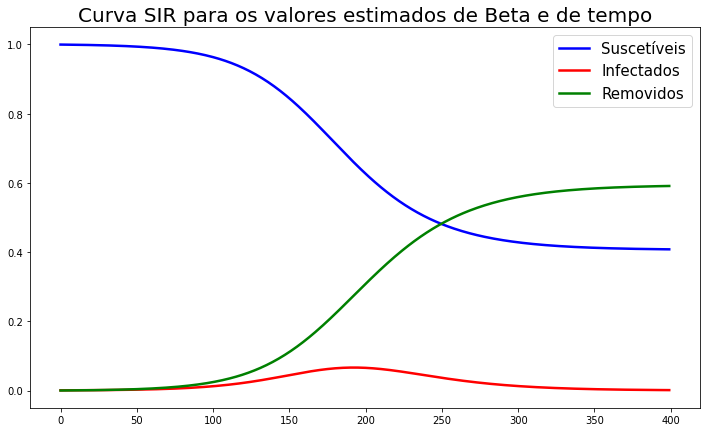

In [130]:
# Condicoes iniciais
y0 = S0, I0, R0
# Integracao do modelo SIR com o beta estimado
ret = odeint(EDO, y0, t, args=(N, melhor_beta, gamma, d))
S, I, R = ret.T

plt.figure(figsize = (12,7))
plt.title('Curva SIR para os valores estimados de Beta e de tempo', fontsize = 20)
plt.plot(S/N, label = 'Suscetíveis', color = 'blue', linewidth = 2.5)
plt.plot(I/N, label = 'Infectados', color = 'red',linewidth = 2.5)
plt.plot(R/N, label = 'Removidos', color = 'green', linewidth = 2.5)
plt.legend(fontsize = 15)
plt.show()

#### Análise do ajuste

In [131]:
estimativa_inicio_da_serie = melhor_tempo
sao_paulo_treino_editado = list([np.nan for i in range(estimativa_inicio_da_serie)])
sao_paulo_treino_editado = sao_paulo_treino_editado + list(sao_paulo_treino['infectados'])
sao_paulo_treino_editado = sao_paulo_treino_editado + list([np.nan for i in range(len(I) - len(sao_paulo_treino_editado))])

sao_paulo_teste_editado = list([np.nan for i in range(estimativa_inicio_da_serie)]) 
sao_paulo_teste_editado = sao_paulo_teste_editado + list([np.nan for i in range(len(sao_paulo_treino['infectados']))])
sao_paulo_teste_editado = sao_paulo_teste_editado + list(sao_paulo_teste['infectados'])
sao_paulo_teste_editado = sao_paulo_teste_editado +  list([np.nan for i in range(len(I) - len(sao_paulo_teste_editado))])


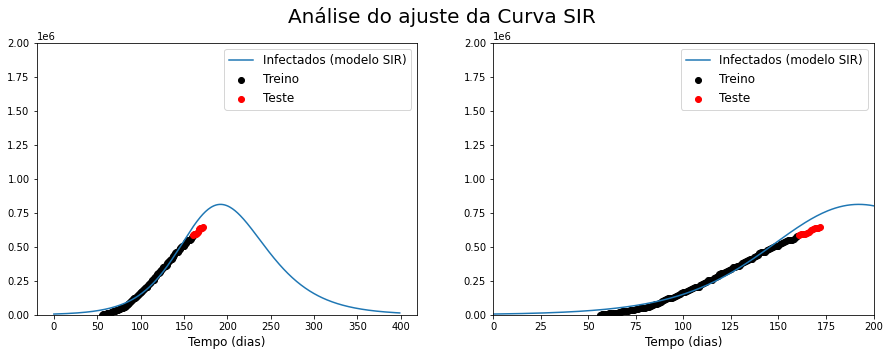

In [132]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Análise do ajuste da Curva SIR', fontsize = 20)

axs[0].plot(I, label = 'Infectados (modelo SIR)')
axs[0].scatter(x = np.arange(len(sao_paulo_treino_editado)), y = sao_paulo_treino_editado, color = 'black', label = 'Treino')
axs[0].scatter(x = np.arange(len(sao_paulo_teste_editado)), y = sao_paulo_teste_editado, color = 'red', label = 'Teste')
axs[0].set_ylim([-50,2000000])
axs[0].legend(fontsize = 12)

axs[1].plot(I, label = 'Infectados (modelo SIR)')
axs[1].scatter(x = np.arange(len(sao_paulo_treino_editado)), y = sao_paulo_treino_editado, color = 'black', label = 'Treino')
axs[1].scatter(x = np.arange(len(sao_paulo_teste_editado)), y = sao_paulo_teste_editado, color = 'red', label = 'Teste')
axs[1].set_xlim([0,200])
axs[1].set_ylim([-50,2000000])
axs[1].legend(fontsize = 12)

for ax in fig.axes:
    plt.sca(ax)
    plt.xlabel('Tempo (dias)', fontsize = 12)

plt.show()


#### Análise de cenários

**Cenários**
* Otimista: Taxa de contato 10% menor
* Otimista: Taxa de contato 10% maior

In [133]:
cenario = 0.1

R_zero_otimista = R_0(melhor_beta*(1-cenario), gamma, d)
R_zero_pessimista = R_0(melhor_beta*(1+cenario), gamma, d)

print('No cenário otimista, as taxas são:')
print('--- beta = {}'.format(round(melhor_beta*(1-cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_otimista, 2)))
print('\n')
print('No cenário pessista, as taxas são:')
print('--- beta = {}'.format(round(melhor_beta*(1+cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_pessimista, 2)))

No cenário otimista, as taxas são:
--- beta = 0.09
--- R_0 = 1.36


No cenário pessista, as taxas são:
--- beta = 0.11
--- R_0 = 1.67


In [134]:
# SIR Otimista
ret_otimista = odeint(EDO, y0, t, args=(N, melhor_beta*(1-cenario), gamma, d))
_, I_otimista, _ = ret_otimista.T

# Sir pessismista
ret_pessimista = odeint(EDO, y0, t, args=(N, melhor_beta*(1+cenario), gamma, d))
_, I_pessimista, _ = ret_pessimista.T

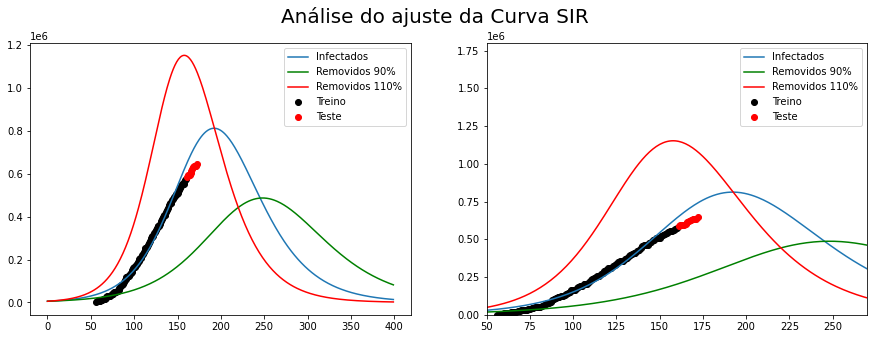

In [135]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Análise do ajuste da Curva SIR', fontsize = 20)

axs[0].plot(I, label = 'Infectados')
axs[0].plot(I_otimista, label = 'Removidos 90%', color = 'green')
axs[0].plot(I_pessimista, label = 'Removidos 110%', color = 'red')
axs[0].scatter(x = np.arange(len(sao_paulo_treino_editado)), y = sao_paulo_treino_editado, color = 'black', label = 'Treino')
axs[0].scatter(x = np.arange(len(sao_paulo_teste_editado)), y = sao_paulo_teste_editado, color = 'red', label = 'Teste')
axs[0].legend(fontsize = 10)

axs[1].plot(I, label = 'Infectados')
axs[1].plot(I_otimista, label = 'Removidos 90%', color = 'green')
axs[1].plot(I_pessimista, label = 'Removidos 110%', color = 'red')
axs[1].scatter(x = np.arange(len(sao_paulo_treino_editado)), y = sao_paulo_treino_editado, color = 'black', label = 'Treino')
axs[1].scatter(x = np.arange(len(sao_paulo_teste_editado)), y = sao_paulo_teste_editado, color = 'red', label = 'Teste')
axs[1].set_xlim([50,270])
axs[1].set_ylim([-50,1800000])
axs[1].legend(fontsize = 10)

plt.show()

### 5.3) Estimativa do número de leitos de UTI

* **Estimativa do número de infectados com necessidade de UTI**

\

\begin{equation}
infectados-com-necessidade-de-uti = 0.0196 * infectados \tag{2}
\end{equation}

\

In [136]:
curva_SIR_infectados_com_necessidade_de_uti = 0.0196 * I
curva_SIR_otimista_infectados_com_necessidade_de_uti = 0.0196 * I_otimista
curva_SIR_pessimista_infectados_com_necessidade_de_uti = 0.0196 * I_pessimista

estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_treino = [np.nan if i == np.nan else 0.0196 * i for i in sao_paulo_treino_editado]
estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_teste = [np.nan if i == np.nan else 0.0196 * i for i in sao_paulo_teste_editado]

In [137]:
# Preparando o vetor de data para plotar no gráfico final
sao_paulo_data_minima = min(sao_paulo_treino['data_estimada_acometimento'])
sao_paulo_data_minima = datetime(int(sao_paulo_data_minima[:4]), int(sao_paulo_data_minima[5:7]), int(sao_paulo_data_minima[8:]))
sao_paulo_data_minima = sao_paulo_data_minima + timedelta(-150)
sao_paulo_serie_data = [sao_paulo_data_minima+timedelta(i) for i in range(400)]
sao_paulo_serie_data = [datetime.date(i) for i in sao_paulo_serie_data]

In [138]:
tabela_demanda_por_leitos_uti = pd.DataFrame({'Data_estimada' : sao_paulo_serie_data, 
                                              'Infectados_SIR' : curva_SIR_infectados_com_necessidade_de_uti,
                                              'Infectados_UTI_SIR_otimista' : curva_SIR_otimista_infectados_com_necessidade_de_uti,
                                              'Infectados_UTI_SIR_pessimista' : curva_SIR_pessimista_infectados_com_necessidade_de_uti,
                                              'Estimativa_infectados_treino' : estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_treino,
                                              'Estimativa_infectados_teste' : estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_teste})

tabela_filtrada = tabela_demanda_por_leitos_uti.iloc[10:150]

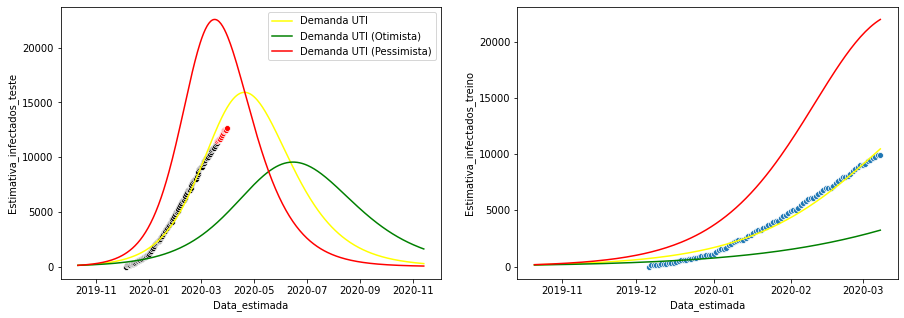

In [139]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.lineplot(x="Data_estimada", y="Infectados_SIR", data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'yellow', label = 'Demanda UTI')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_otimista", data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'green', label = 'Demanda UTI (Otimista)')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_pessimista", data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'red', label = 'Demanda UTI (Pessimista)')
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_treino",  data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'black')
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_teste",  data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'red')

sns.lineplot(x="Data_estimada", y="Infectados_SIR", data=tabela_filtrada, ax = ax2, color = 'yellow')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_otimista", data=tabela_filtrada, ax = ax2, color = 'green')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_pessimista", data=tabela_filtrada, ax = ax2, color = 'red')
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_treino",  data=tabela_filtrada, ax = ax2)
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_teste",  data=tabela_filtrada, ax = ax2, color = 'red')

plt.show()